In [2]:
# imports
import pickle

import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [3]:
# load the Model
with open('../models/mlp_classifier.pkl', 'rb') as f:
    model = pickle.load(f)


def normalise_data(round_num: int,  team_score: int,  current_side: str, starting_side: str,  buy_type: str) -> pd.DataFrame:
  df = pd.read_feather(
      '../data/processed/team_score_and_buy__dataset__training.feather')
  
  label_encoder = preprocessing.LabelEncoder()
  categorical_value_columns = [
      'buy_type', 'starting_side', 'current_side']

  unnecessary_columns = ['match_name', 'client_name', 'round_end_reason', 'round_win', 'team',
                         'map_name',
                         'round_start_eq_val', 'spend', '_data_id', '_match_id', 'match_win']

  df.drop(labels=unnecessary_columns, inplace=True, axis=1)

  # for c in categorical_value_columns:
  #   df[c] = label_encoder.fit_transform(df[c])

  input_data = pd.DataFrame([{'round_num': round_num,  'team_score': team_score,
                            'current_side': current_side, 'starting_side': starting_side, 'buy_type': buy_type}])
  
  
  for c in categorical_value_columns:
    label_encoder.fit(list(df[c]))
    input_data[c] = label_encoder.transform(input_data[c])
    df[c] = label_encoder.transform(df[c])
    

  col = df.columns
  standscl = preprocessing.StandardScaler()
  standscl.fit(df)

  df = df[input_data.columns]
  normalised_input_data = standscl.transform(input_data)
  normalised_input_data = pd.DataFrame(input_data, columns=col)

  return normalised_input_data

def get_possible_buytypes(team_budget:int):
  affordable_buy_types = list()
  if(team_budget >= 0):
    affordable_buy_types.append('Full Eco')  

  if(team_budget >= 2000):
    affordable_buy_types.append('Eco')

  if(team_budget >= 6000):
    affordable_buy_types.append('Half Buy')

  if(team_budget >= 20000):
    affordable_buy_types.append('Full Buy')

  return affordable_buy_types


/Users/moritz/miniconda3/envs/fusionbase_3.9/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/moritz/miniconda3/envs/fusionbase_3.9/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [26]:
def get_best_decision(ROUND_NUM, TEAM_SCORE, CURRENT_SIDE, STARTING_SIDE, BUDGET, log=True):
  possible_buy_types = get_possible_buytypes(BUDGET)
  if log:
    print(f"The possible buy types are: {', '.join(possible_buy_types)}")
  best_win_prob = 0
  best_buy_type = possible_buy_types[0]
  for bt in possible_buy_types:
    normalised_input_data = normalise_data(
        ROUND_NUM, TEAM_SCORE, CURRENT_SIDE, STARTING_SIDE, buy_type=bt)
    win_probability = model.predict_proba(normalised_input_data.values)[0][1]
    if log:
      print(win_probability)
    if win_probability > best_win_prob:
        best_win_prob = win_probability
        best_buy_type = bt

  return best_win_prob, best_buy_type


def get_prob_for_decision(ROUND_NUM, TEAM_SCORE, CURRENT_SIDE, STARTING_SIDE, DECISION):
  normalised_input_data = normalise_data(
      ROUND_NUM, TEAM_SCORE, CURRENT_SIDE, STARTING_SIDE, buy_type=DECISION)
  win_probability = model.predict_proba(normalised_input_data.values)[0][1]
  return win_probability


In [27]:
# Adjust Situation to predict buy type

ROUND_NUM = 16
TEAM_SCORE = 4
CURRENT_SIDE = 'CT'
STARTING_SIDE = 'T'

BUDGET = 12000;


best_win_prob, best_buy_type = get_best_decision(ROUND_NUM, TEAM_SCORE, CURRENT_SIDE, STARTING_SIDE, BUDGET)

print('================================================================')
print(f"""The best buy type in the current Situation would be: {best_buy_type}. 
The game win probability would be {best_win_prob}.""")

The possible buy types are: Full Eco, Eco, Half Buy
0.1805373711200488
0.2499955423436578
0.15190356606362557
The best buy type in the current Situation would be: Eco. 
The game win probability would be 0.2499955423436578.


In [100]:
data = pd.read_feather(
      '../data/processed/team_score_and_buy__dataset__training.feather')

data = data.sample(1000)

data['probability_for_decision'] = data.apply(lambda x: get_prob_for_decision(x.round_num, x.team_score, x.current_side, x.starting_side, x.buy_type), axis=1)
data['probability_for_best_decision'] = data.apply(lambda x: get_best_decision(x.round_num, x.team_score, x.current_side, x.starting_side, x.spend, log=False)[0], axis=1)

In [112]:

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

mpl.use('pgf')

sns.set_theme(style="whitegrid")

# use latex pgf format instead of png
plt.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

<AxesSubplot:xlabel='Type', ylabel='Win Probability'>

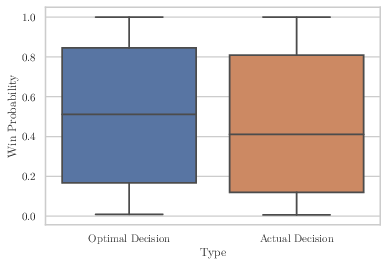

In [113]:
optimal, actual = data['probability_for_best_decision'].reset_index(), data['probability_for_decision'].reset_index()
optimal.columns, actual.columns = ['index', 'Win Probability'], ['index', 'Win Probability']


optimal['Type'] = 'Optimal Decision'
actual['Type'] = 'Actual Decision'

data_to_plot = pd.concat([optimal, actual])
# create seaborn boxplots by group
sns.boxplot(x='Type', y='Win Probability', data=data_to_plot)

# plt.show()
plt.savefig("../reports/figures/comparing_optimal_and_actual.pgf")